Rendering frame 0/364
Rendering frame 1/364
Rendering frame 2/364
Rendering frame 3/364
Rendering frame 4/364
Rendering frame 5/364
Rendering frame 6/364
Rendering frame 7/364
Rendering frame 8/364
Rendering frame 9/364
Rendering frame 10/364
Rendering frame 11/364
Rendering frame 12/364
Rendering frame 13/364
Rendering frame 14/364
Rendering frame 15/364
Rendering frame 16/364
Rendering frame 17/364
Rendering frame 18/364
Rendering frame 19/364
Rendering frame 20/364
Rendering frame 21/364
Rendering frame 22/364
Rendering frame 23/364
Rendering frame 24/364
Rendering frame 25/364
Rendering frame 26/364
Rendering frame 27/364
Rendering frame 28/364
Rendering frame 29/364
Rendering frame 30/364
Rendering frame 31/364
Rendering frame 32/364
Rendering frame 33/364
Rendering frame 34/364
Rendering frame 35/364
Rendering frame 36/364
Rendering frame 37/364
Rendering frame 38/364
Rendering frame 39/364
Rendering frame 40/364
Rendering frame 41/364
Rendering frame 42/364
Rendering frame 43/36

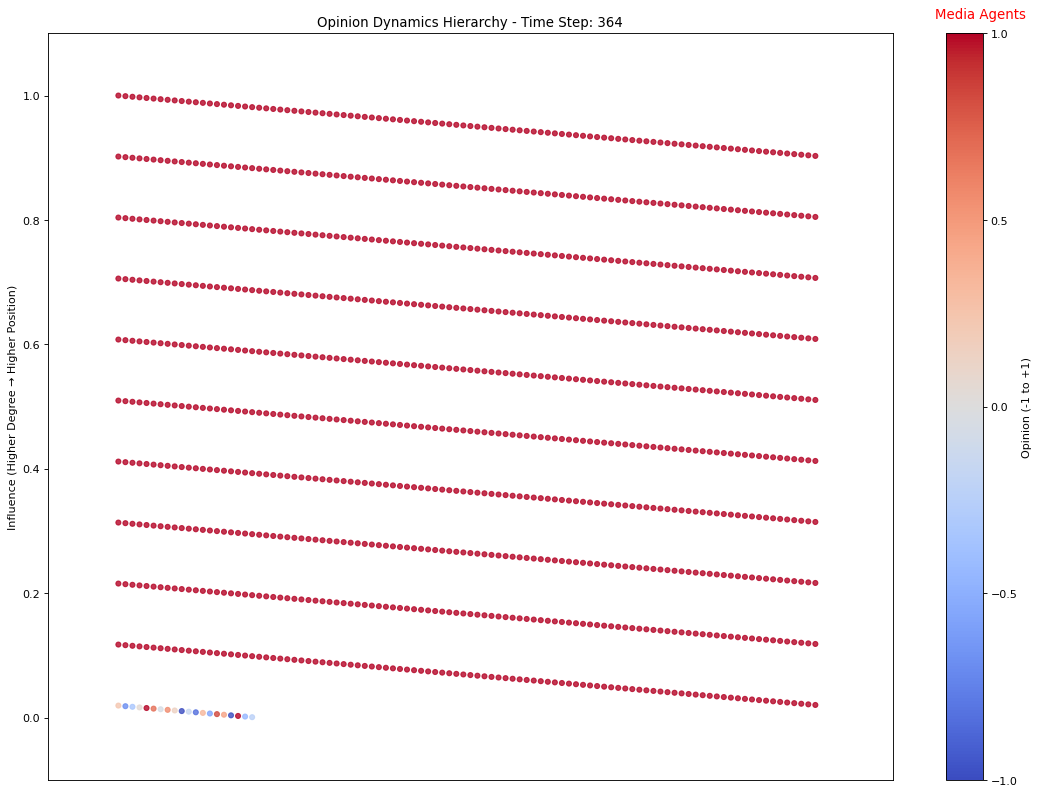

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.cm import ScalarMappable
from io import StringIO

# Set up paths
folder_path = "data/local/IDayTrialRun"
file_title = "FG_epsM0.281_epsSD0.234___OpDuniform_OpM0_OpSD0.2___NetScale-free___NAgents1000___RS720194430___MedDdeterministic-normal_MedN20_MedM0_MedSD0.79"
file_name = file_title + ".csv"
file_path = os.path.join(folder_path, file_name)

# Read the entire file as a string
with open(file_path, 'r') as f:
    file_content = f.read()

# Split the content by the separator
parts = [p.strip() for p in file_content.split('-----------------') if p.strip()]

# Parse biconnections (edges)
edges = []
for line in parts[0].splitlines()[1:]:  # Skip header line
    if not line.strip() or line.count(',') < 1:
        continue
    # Find the first two valid agent IDs
    agents = []
    for cell in line.split(','):
        cell = cell.strip()
        if cell and cell != '':  # Check for non-empty strings
            if cell.isdigit() or (cell[0] == '-' and cell[1:].isdigit()):
                agents.append(int(cell))
                if len(agents) == 2:
                    break
    if len(agents) == 2:
        edges.append(tuple(agents))

# Parse media positions
media = {}
for line in parts[1].splitlines()[1:]:  # Skip header
    if not line.strip():
        continue
    # Split into house ID and opinion
    cells = line.split(',', 1)
    house_id = cells[0].strip()
    if not house_id:
        continue
    # Extract opinion from bracket format
    opinion_str = cells[1].strip().replace('[', '').replace(']', '')
    if opinion_str:
        try:
            media[int(house_id)] = float(opinion_str)
        except ValueError:
            continue
# Parse the time series data with pandas
df = pd.read_csv(StringIO(parts[3]))
df['opinion'] = df['opinion'].str.replace('[', '').str.replace(']', '').astype(float)

# Create combined agent set
all_agents = list(set(df['agentID']) | set(media.keys()))

# Assign degrees to media agents (higher than any regular agent)
max_degree = df['Degree'].max()
media_degree = max_degree * 10  # Ensure media appear at top with significant separation

# Create degree mapping
agent_degrees = {}
for agent_id in all_agents:
    if agent_id in media:
        agent_degrees[agent_id] = media_degree
    else:
        # Get first occurrence degree (static in model)
        agent_degrees[agent_id] = df[df['agentID'] == agent_id]['Degree'].iloc[0]

# Assign vertical positions based on degree (log scale for better distribution)
max_deg = max(agent_degrees.values())
min_deg = min(agent_degrees.values())

# Use logarithmic scaling to spread out high-degree agents
y_positions = {}
x_positions = {}  # Horizontal positions

# Sort agents by degree for consistent ordering
sorted_agents = sorted(all_agents, key=lambda x: agent_degrees[x], reverse=True)

# Assign vertical positions based on rank (not raw degree)
num_agents = len(sorted_agents)
for idx, agent_id in enumerate(sorted_agents):
    # Normalized position from top (1) to bottom (0)
    y_positions[agent_id] = 1 - (idx / num_agents)
    
    # Horizontal position based on agent ID for consistency
    # This spreads agents while maintaining relative positions
    x_positions[agent_id] = (agent_id % 100) / 100  # Use modulo to distribute

# Create figure and color mapping
fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
cmap = plt.cm.coolwarm
norm = mcolors.Normalize(vmin=-1, vmax=1)
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm, ax=ax, label='Opinion (-1 to +1)')
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
ax.set_title('Opinion Dynamics Hierarchy')
ax.set_ylabel('Influence (Higher Degree → Higher Position)')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.get_xaxis().set_visible(False)  # Hide x-axis

# Skip edge plotting for large networks to reduce clutter
# OPTIONAL: Uncomment to show edges (only recommended for small networks)
for edge in edges:
    if edge[0] in x_positions and edge[1] in x_positions:
        ax.plot(
            [x_positions[edge[0]], x_positions[edge[1]]],
            [y_positions[edge[0]], y_positions[edge[1]]],
            'k-', alpha=0.01, linewidth=0.3
        )

# Create initial scatter plot
initial_opinions = []
for agent_id in sorted_agents:  # Use sorted order for consistency
    if agent_id in media:
        initial_opinions.append(media[agent_id])
    else:
        agent_data = df[(df['agentID'] == agent_id) & (df['timeStep'] == 0)]
        initial_opinions.append(agent_data['opinion'].iloc[0] if not agent_data.empty else 0)

# Create scatter plot
scatter = ax.scatter(
    [x_positions[aid] for aid in sorted_agents],
    [y_positions[aid] for aid in sorted_agents],
    c=initial_opinions, cmap=cmap, vmin=-1, vmax=1, s=20, alpha=0.8
)

# Add media label
ax.text(1.05, 1.02, 'Media Agents', transform=ax.transAxes, fontsize=12, color='red')

# Animation update function
def update(frame):
    print(f"Rendering frame {frame}/{max_time_step}")  # Progress indicator
    
    current_opinions = []
    for agent_id in sorted_agents:  # Maintain sorted order
        if agent_id in media:
            # Media opinion fixed
            current_opinions.append(media[agent_id])
        else:
            # Get opinion for current time step
            agent_data = df[(df['agentID'] == agent_id) & (df['timeStep'] == frame)]
            if not agent_data.empty:
                current_opinions.append(agent_data['opinion'].iloc[0])
            else:
                # If no data, keep previous opinion
                current_opinions.append(scatter.get_array()[sorted_agents.index(agent_id)])
    
    # Update colors
    scatter.set_array(np.array(current_opinions))
    
    # Update title
    ax.set_title(f'Opinion Dynamics Hierarchy - Time Step: {frame}')
    
    return scatter,

# Get unique time steps
time_steps = sorted(df['timeStep'].unique())
max_time_step = time_steps[-1]

# Create writer
writer = FFMpegWriter(fps=10, metadata=dict(artist='Opinion Dynamics Model'), bitrate=1800)

# Save animation
fig.tight_layout()

with writer.saving(fig, "opinion_dynamics.mp4", dpi=80):
    for frame in time_steps:
        update(frame)
        writer.grab_frame()

print("Animation saved successfully!")

In [23]:

media_df = pd.read_csv(StringIO(parts[2]))
print(media_df.columns)

Index(['Initial Media Positions (House ID', ' opinion)'], dtype='object')
